<a href="https://colab.research.google.com/github/kosesma/ARBK_Praktikum/blob/main/COX_Modell_aktuell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datenvorbereitung und ausführen des Cox Modell

In [1]:
from google.colab import files

# Bu kod çalışınca altta "Dosya Seç" butonu çıkacak
uploaded = files.upload()

Saving training_set-B_all_merged.csv to training_set-B_all_merged.csv


In [2]:
import pandas as pd
import numpy as np
!pip install lifelines
from lifelines import CoxPHFitter

# 1. Daten laden
df = pd.read_csv("training_set-B_all_merged.csv")

# 2. Datenvorbereitung (Cleaning & Feature Engineering)

# A. Sortieren nach Patient und Zeit (wichtig für Historie)
df = df.sort_values(by=['patient_id', 'delta_edss_time0'])

# B. Lücken im EDSS füllen (Forward Fill pro Patient)
# Wenn ein Wert fehlt, nehmen wir den vom vorigen Visit
df['edss_as_evaluated_by_clinician_1'] = df.groupby('patient_id')['edss_as_evaluated_by_clinician_1'].ffill()
# Falls der allererste fehlt, mit dem Median aller füllen
df['edss_as_evaluated_by_clinician_1'] = df['edss_as_evaluated_by_clinician_1'].fillna(df['edss_as_evaluated_by_clinician_1'].median())

# C. Features berechnen (auf dem gesamten Verlauf)
# Schübe zählen (Kumulativ)
df['is_relapse_clean'] = df['is_relapse_1'].fillna(0)
df['num_relapses'] = df.groupby('patient_id')['is_relapse_clean'].cumsum()

# Symptome & Geschlecht kodieren
df['spinal_cord_symptom_1'] = df['spinal_cord_symptom_1'].astype(int)
df['brainstem_symptom_1'] = df['brainstem_symptom_1'].astype(int)
df['eye_symptom_1'] = df['eye_symptom_1'].astype(int)
df['supratentorial_symptom_1'] = df['supratentorial_symptom_1'].astype(int)
df['sex_encoded'] = df['sex_1'].map({'female': 0, 'male': 1})

# D. Reduktion auf EINE Zeile pro Patient (Baseline-Ansatz)
# Wir nehmen den ersten bekannten Stand vor Start der Studie (Zeitpunkt 0)
# Da wir sortiert haben, ist .tail(1) der aktuellste Eintrag (Baseline).
df_baseline = df.groupby('patient_id').head(1).copy()

# E. Progression Rate zum Zeitpunkt 0 berechnen
# Rate = (Aktueller EDSS) / (Jahre seit Diagnose)
df_baseline['disease_duration_years'] = df_baseline['time_since_onset_1'] / 365.25
df_baseline['disease_duration_years'] = df_baseline['disease_duration_years'].replace(0, 0.01) # Schutz vor /0
df_baseline['progression_rate'] = df_baseline['edss_as_evaluated_by_clinician_1'] / df_baseline['disease_duration_years']

# 3. Das Cox-Modell vorbereiten

# Spalten umbenennen für Klarheit
df_baseline = df_baseline.rename(columns={
    'outcome_time_1': 'duration',
    'outcome_occurred_1': 'event'
})

# Feature-Liste definieren
features = [
    'sex_encoded',
    'age_at_onset_1',
    'edss_as_evaluated_by_clinician_1', # EDSS zum Startzeitpunkt
    'progression_rate',                 # Wie schnell wurde es bis heute schlechter?
    'num_relapses',                     # Wie viele Schübe gab es bis heute?
    'spinal_cord_symptom_1',            # Kritische Lage?
    'brainstem_symptom_1',
    'eye_symptom_1',
    'supratentorial_symptom_1',
    'duration',                         # Ziel-Variable Zeit
    'event'                             # Ziel-Variable Event
]

# Filtern (nur vollständige Zeilen)
df_final = df_baseline[features].dropna()

print(f"Modell wird trainiert mit {len(df_final)} Patienten.")

# 4. Modell fitten
cph = CoxPHFitter()
cph.fit(df_final, duration_col='duration', event_col='event')

# Ergebnis anzeigen
cph.print_summary()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=69dc6d3bd05448a21eaa9c9b6723841b100d86257042612a7354a6f3e9ab7ea0
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
Modell wird trainiert mit 510 Patienten.


<lifelines.CoxPHFitter: fitted with 510 total observations, 384 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 510
number of events observed = 126
   partial log-likelihood = -676.86
         time fit was run = 2025-12-10 10:34:40 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
sex_encoded                       0.28      1.32      0.19           -0.10            0.66                0.90                1.93
age_at_onset_1                    0.01      1.01      0.01           -0.01            0.03                0.99                1.03
edss_as_evaluated_by_clinician_1  0.19      1.21      0.08            0.03            0.36                1.03                1.43
progression_rate                 -0.77      0.46      0.27           -1.30           -0.23                0.27                0.79
num_relapses                     -0.23      0.80      0.20           -0.63            0.17                0.53                1.18
spinal_cord_symptom_1             0.14      1.15      0.28           -0.40            0.68                0.67                1.98
brainstem_symptom_1              -0.16      0.85      0.31           -0.76            0.44                0.47                1.56
eye_symptom_1                     0.25      1.29      0.32           -0.39            0.89                0.68                2.43
supratentorial_symptom_1         -0.04      0.96      0.28           -0.58            0.51                0.56                1.66

                                  cmp to     z      p  -log2(p)
covariate                                                      
sex_encoded                         0.00  1.43   0.15      2.72
age_at_onset_1                      0.00  1.00   0.32      1.65
edss_as_evaluated_by_clinician_1    0.00  2.31   0.02      5.57
progression_rate                    0.00 -2.82 <0.005      7.69
num_relapses                        0.00 -1.13   0.26      1.94
spinal_cord_symptom_1               0.00  0.52   0.60      0.73
brainstem_symptom_1                 0.00 -0.51   0.61      0.72
eye_symptom_1                       0.00  0.77   0.44      1.18
supratentorial_symptom_1            0.00 -0.13   0.90      0.16
---
Concordance = 0.62
Partial AIC = 1371.71
log-likelihood ratio test = 19.08 on 9 df
-log2(p) of ll-ratio test = 5.35

In [3]:
# 1. Hatalı değişkeni listeden çıkarıyoruz
if 'progression_rate' in features:
    features.remove('progression_rate')

# Veriyi tekrar filtrele
df_final = df_baseline[features].dropna()

print(f"Yeni özellik listesi: {features}")
print("-" * 30)

# 2. Cox Modelini 'penalizer' (L2 Regularization) ile kuruyoruz
# Proje dosyasında 'CoxPH models with regularization' istendiği için bu adım kritik.
# penalizer=0.1 yaygın ve güvenli bir başlangıç değeridir.
cph_reg = CoxPHFitter(penalizer=0.1)

cph_reg.fit(df_final, duration_col='duration', event_col='event')

# 3. Sonuçları yazdır
cph_reg.print_summary()

Yeni özellik listesi: ['sex_encoded', 'age_at_onset_1', 'edss_as_evaluated_by_clinician_1', 'num_relapses', 'spinal_cord_symptom_1', 'brainstem_symptom_1', 'eye_symptom_1', 'supratentorial_symptom_1', 'duration', 'event']
------------------------------


<lifelines.CoxPHFitter: fitted with 510 total observations, 384 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 510
number of events observed = 126
   partial log-likelihood = -682.92
         time fit was run = 2025-12-10 10:34:52 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
sex_encoded                       0.19      1.21      0.16           -0.13            0.51                0.88                1.66
age_at_onset_1                    0.00      1.00      0.01           -0.01            0.02                0.99                1.02
edss_as_evaluated_by_clinician_1  0.05      1.05      0.07           -0.09            0.19                0.92                1.21
num_relapses                     -0.26      0.77      0.16           -0.57            0.06                0.56                1.07
spinal_cord_symptom_1             0.09      1.10      0.19           -0.28            0.46                0.76                1.59
brainstem_symptom_1              -0.20      0.82      0.19           -0.57            0.18                0.56                1.19
eye_symptom_1                     0.07      1.07      0.19           -0.31            0.45                0.73                1.56
supratentorial_symptom_1         -0.11      0.90      0.18           -0.46            0.25                0.63                1.28

                                  cmp to     z    p  -log2(p)
covariate                                                    
sex_encoded                         0.00  1.15 0.25      2.00
age_at_onset_1                      0.00  0.49 0.62      0.68
edss_as_evaluated_by_clinician_1    0.00  0.71 0.48      1.07
num_relapses                        0.00 -1.57 0.12      3.11
spinal_cord_symptom_1               0.00  0.48 0.63      0.67
brainstem_symptom_1                 0.00 -1.04 0.30      1.74
eye_symptom_1                       0.00  0.36 0.72      0.47
supratentorial_symptom_1            0.00 -0.59 0.56      0.85
---
Concordance = 0.59
Partial AIC = 1381.83
log-likelihood ratio test = 6.96 on 8 df
-log2(p) of ll-ratio test = 0.89

Variablen zusammenfassung:

- sex_encoded : 0 weiblich, 1 männlich (Aus Rohdaten nur zu 0,1 umgeformt)
- age_at_onset_1 : wie alt war der Patient bei diagnose/erst Besuch (Aus Rohdaten)
- edss_as_evaluated_by_clinician_1 : Schweregrad der körperlichen Beeinträchtigung zu Beginn (Rohdaten )
- num_relapses : Anzahl Schübe pro Patient (is_relapse_1 aus Datei überall wo 1 wird auf addiert)
- progression_rate Veränderung EDSS über Jahr nicht Tag (Korrekturfaktor zu Edss_as... da die ähnliche Sache beschreiben)
- spinal_cord_symptom_1 ,brainstem_symptom_1, supratentorial_symptom_1, eye_symptom_1

In [4]:
from lifelines import CoxTimeVaryingFitter

# --- ADIM 1: EKSİK OLAN HESAPLAMA ---
# Önce ana veri setine (df) geçmiş veriyi (prev_edss) ekliyoruz.
# Bu kod çalışmadan aşağıdaki "long_cols" bu sütunu bulamaz!
df = df.sort_values(by=['patient_id', 'delta_edss_time0']) # Sıralama garanti olsun
df['prev_edss'] = df.groupby('patient_id')['edss_as_evaluated_by_clinician_1'].shift(1)
df['prev_edss'] = df['prev_edss'].fillna(df['edss_as_evaluated_by_clinician_1'])

# --- ADIM 2: SÜTUNLARI SEÇME ---
long_cols = [
    'patient_id',
    'delta_edss_time0',
    'edss_as_evaluated_by_clinician_1',
    'is_relapse_clean',
    'sex_encoded',
    'age_at_onset_1',
    'prev_edss'  # Artık bu sütun var, hata vermez.
]

# Ana df'den kopyalıyoruz
df_long = df[long_cols].copy()

# Zamanı Yıla Çevirelim
df_long['time'] = df_long['delta_edss_time0'] / 365.25

# --- ADIM 3: START-STOP FORMATI ---
df_long = df_long.sort_values(['patient_id', 'time'])
df_long['start'] = df_long.groupby('patient_id')['time'].shift(1)
df_long['start'] = df_long['start'].fillna(0)
df_long['stop'] = df_long['time']

# Geçerli aralıkları alalım
df_long = df_long[df_long['start'] < df_long['stop']]

# Olayı (Event) tanımlayalım
df_long = df_long.rename(columns={'is_relapse_clean': 'event'})

print(f"Time-Varying Model için satır sayısı: {len(df_long)}")
print("-" * 30)

# --- ADIM 4: MODELİ KURMA ---
ctv = CoxTimeVaryingFitter(penalizer=0.1)

ctv.fit(df_long,
        id_col='patient_id',
        event_col='event',
        start_col='start',
        stop_col='stop',
        show_progress=True)

# Sonuçları göster
ctv.print_summary()

Time-Varying Model için satır sayısı: 3786
------------------------------
Iteration 1: norm_delta = 3.37e-01, step_size = 0.9500, log_lik = -1892.98446, newton_decrement = 3.15e+01, seconds_since_start = 0.1
Iteration 2: norm_delta = 2.67e-02, step_size = 0.9500, log_lik = -1861.10823, newton_decrement = 1.85e-01, seconds_since_start = 0.2
Iteration 3: norm_delta = 1.39e-03, step_size = 0.9500, log_lik = -1860.92330, newton_decrement = 4.95e-04, seconds_since_start = 0.5
Iteration 4: norm_delta = 7.31e-05, step_size = 1.0000, log_lik = -1860.92281, newton_decrement = 1.24e-06, seconds_since_start = 0.8
Iteration 5: norm_delta = 3.43e-10, step_size = 1.0000, log_lik = -1860.92281, newton_decrement = 2.76e-17, seconds_since_start = 1.2
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 3786 periods, 502 subjects, 331 events>
         event col = 'event'
         penalizer = 0.1
number of subjects = 502
 number of periods = 3786
  number of events = 331
partial log-likelihood = -1860.92
  time fit was run = 2025-12-10 10:34:58 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
delta_edss_time0                 -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
edss_as_evaluated_by_clinician_1  0.04      1.04      0.04           -0.03            0.11                0.97                1.11
sex_encoded                      -0.01      0.99      0.08           -0.17            0.15                0.84                1.16
age_at_onset_1                   -0.01      0.99      0.00           -0.02           -0.01                0.98                0.99
prev_edss                        -0.00      1.00      0.04           -0.07            0.07                0.93                1.07
time                             -0.35      0.70      0.07           -0.49           -0.21                0.61                0.81

                                  cmp to     z      p  -log2(p)
covariate                                                      
delta_edss_time0                    0.00 -4.76 <0.005     18.98
edss_as_evaluated_by_clinician_1    0.00  1.07   0.29      1.81
sex_encoded                         0.00 -0.10   0.92      0.12
age_at_onset_1                      0.00 -3.65 <0.005     11.89
prev_edss                           0.00 -0.01   0.99      0.02
time                                0.00 -4.76 <0.005     18.98
---
Partial AIC = 3733.85
log-likelihood ratio test = 64.12 on 6 df
-log2(p) of ll-ratio test = 37.16

# Visualisierung

<Figure size 1000x600 with 0 Axes>

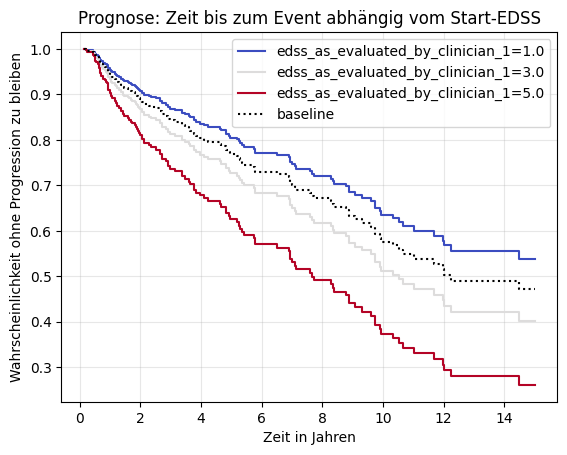

<Figure size 1000x600 with 0 Axes>

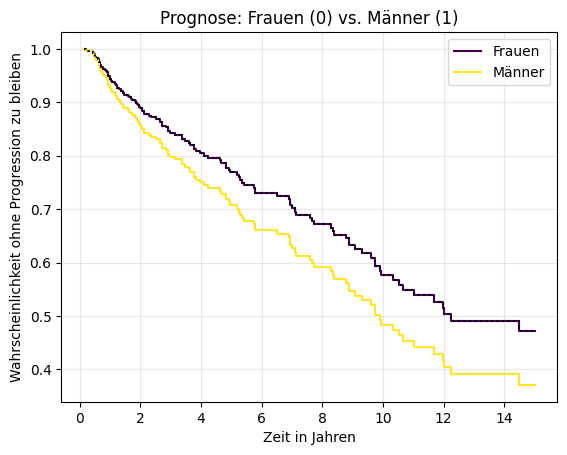

In [5]:
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Graph A: Vergleich verschiedener EDSS-Startwerte
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# Wir plotten die Vorhersage für Patienten mit Start-EDSS 1.0, 3.0 und 5.0
cph.plot_partial_effects_on_outcome(
    covariates='edss_as_evaluated_by_clinician_1',
    values=[1.0, 3.0, 5.0],
    cmap='coolwarm' # Farben von blau (niedrig) bis rot (hoch)
)

plt.title("Prognose: Zeit bis zum Event abhängig vom Start-EDSS")
plt.xlabel("Zeit in Jahren")
plt.ylabel("Wahrscheinlichkeit ohne Progression zu bleiben")
plt.grid(True, alpha=0.3)
plt.show()

# -------------------------------------------------------
# Graph B: Vergleich Frauen vs. Männer
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# sex_encoded: 0=Frau, 1=Mann
cph.plot_partial_effects_on_outcome(
    covariates='sex_encoded',
    values=[0, 1],
    cmap='viridis'
)

plt.title("Prognose: Frauen (0) vs. Männer (1)")
plt.xlabel("Zeit in Jahren")
plt.ylabel("Wahrscheinlichkeit ohne Progression zu bleiben")
plt.legend(['Frauen', 'Männer'])
plt.grid(True, alpha=0.3)
plt.show()


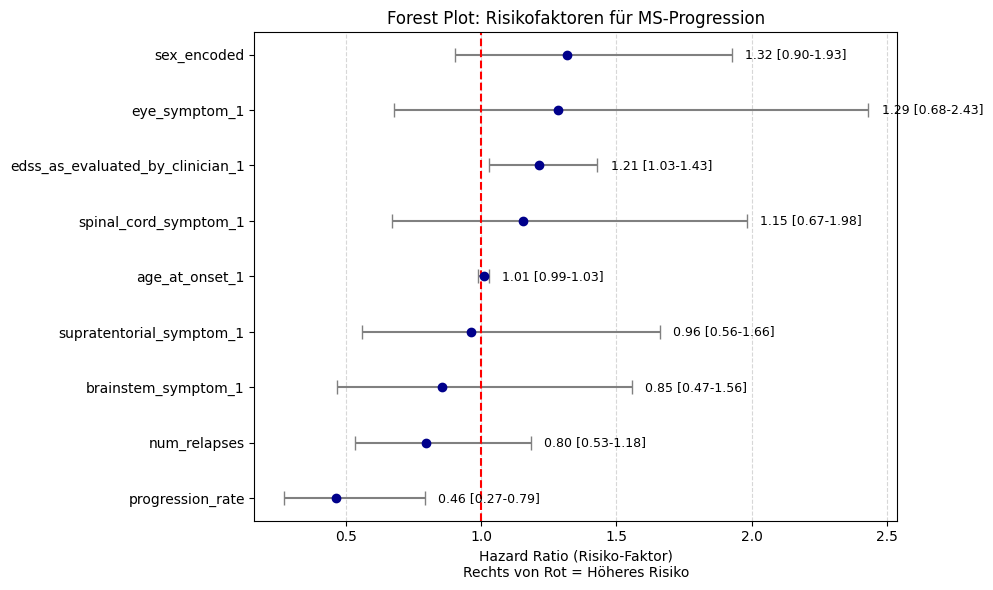

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Daten aus dem Modell extrahieren
summary = cph.summary
# Wir brauchen exp(coef) (=Hazard Ratio) und die Intervalle
df_plot = summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']].copy()
df_plot.columns = ['HR', 'Lower_CI', 'Upper_CI']

# Sortieren, damit das Wichtigste oben steht
df_plot = df_plot.sort_values('HR', ascending=True)

# 2. Plot erstellen
plt.figure(figsize=(10, 6))

# Fehlerbalken zeichnen
# y = Positionen der Balken
y_pos = range(len(df_plot))

# Fehler berechnen (Abstand vom Punkt zum oberen/unteren Ende)
xerr_low = df_plot['HR'] - df_plot['Lower_CI']
xerr_high = df_plot['Upper_CI'] - df_plot['HR']

plt.errorbar(
    x=df_plot['HR'],
    y=y_pos,
    xerr=[xerr_low, xerr_high],
    fmt='o',             # 'o' für Punkte
    color='darkblue',    # Farbe der Punkte
    ecolor='gray',       # Farbe der Linien
    capsize=5,           # Endkappen der Linien
    label='Hazard Ratio (95% CI)'
)

# Rote Referenzlinie bei 1 (Neutral)
plt.axvline(x=1, color='red', linestyle='--', label='Kein Effekt (HR=1)')

# Achsenbeschriftung
plt.yticks(y_pos, df_plot.index) # Variablennamen an der Y-Achse
plt.xlabel('Hazard Ratio (Risiko-Faktor)\nRechts von Rot = Höheres Risiko')
plt.title('Forest Plot: Risikofaktoren für MS-Progression')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 3. Werte direkt in den Plot schreiben (Optional, sieht aber profimäßig aus)
for i, (hr, low, high) in enumerate(zip(df_plot['HR'], df_plot['Lower_CI'], df_plot['Upper_CI'])):
    # Text etwas rechts vom Balken platzieren
    plt.text(high + 0.05, i, f"{hr:.2f} [{low:.2f}-{high:.2f}]", va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [8]:
# ---------------------------------------------------------
# KORRIGIERTER SCHRITT 1: Datentrennung
# ---------------------------------------------------------

# 1. Relapse-Modell (Schübe)
# Wir kopieren den Basis-Datensatz
df_relapse = df_baseline.copy()

# Ziel: Das Event ist jetzt ein Schub (is_relapse_1)
# Wir nutzen is_relapse_clean, da wir das oben schon bereinigt haben
if 'is_relapse_clean' in df_relapse.columns:
    df_relapse['event'] = df_relapse['is_relapse_clean'].fillna(0).astype(int)
elif 'is_relapse_1' in df_relapse.columns:
    df_relapse['event'] = df_relapse['is_relapse_1'].fillna(0).astype(int)

print(f"Relapse-Datensatz: {df_relapse['event'].sum()} Events (Schübe)")


# 2. Progression-Modell (EDSS-Verschlechterung)
# Wir kopieren den Basis-Datensatz
df_progression = df_baseline.copy()

# WICHTIG: Die Spalte 'outcome_occurred_1' wurde oben bereits in 'event' umbenannt.
# Das ist bereits unser Progressions-Event, wir müssen es also nicht neu zuweisen,
# nur sicherstellen, dass es sauber ist.
df_progression['event'] = df_progression['event'].fillna(0).astype(int)

print(f"Progression-Datensatz: {df_progression['event'].sum()} Events (Verschlechterung)")


# 3. Features auswählen (ohne die problematische progression_rate)
features_to_use = [
    'sex_encoded',
    'age_at_onset_1',
    'edss_as_evaluated_by_clinician_1', # Basis-EDSS
    'num_relapses',                     # Historie
    'spinal_cord_symptom_1',
    'brainstem_symptom_1',
    'eye_symptom_1',
    'supratentorial_symptom_1',
    'duration',
    'event'
]

# Finale DataFrames erstellen
df_relapse_final = df_relapse[features_to_use].dropna()
df_progression_final = df_progression[features_to_use].dropna()

print("\nFertig: df_relapse_final und df_progression_final stehen bereit.")

Relapse-Datensatz: 156 Events (Schübe)
Progression-Datensatz: 126 Events (Verschlechterung)

Fertig: df_relapse_final und df_progression_final stehen bereit.


In [9]:
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

# Funktion, um den besten Penalizer zu finden und das finale Modell zu trainieren
def optimize_and_fit_cox(df, name):
    print(f"--- Optimiere Modell: {name} ---")

    # Verschiedene Stärken der Regularisierung testen
    # 0 = keine Regularisierung (Standard), 1.0 = sehr stark
    penalizer_candidates = [0.0001, 0.001, 0.01, 0.1, 0.5]

    best_c_index = 0
    best_p = 0

    # 1. Grid Search mit Cross-Validation
    for p in penalizer_candidates:
        cph = CoxPHFitter(penalizer=p)
        try:
            # 5-Fold Cross Validation: Testet Robustheit
            scores = k_fold_cross_validation(cph, df, duration_col='duration', event_col='event', k=5)
            mean_score = np.mean(scores)

            # Fortschritt anzeigen (optional)
            # print(f"Penalizer {p}: C-Index ~ {mean_score:.3f}")

            if mean_score > best_c_index:
                best_c_index = mean_score
                best_p = p
        except:
            continue # Falls ein Wert Fehler wirft, überspringen

    print(f"Bester Penalizer gefunden: {best_p} (Erwarteter C-Index: {best_c_index:.3f})")

    # 2. Finales Modell mit dem besten Wert auf den GANZEN Daten trainieren
    final_model = CoxPHFitter(penalizer=best_p)
    final_model.fit(df, duration_col='duration', event_col='event')

    print(f"Modell '{name}' erfolgreich trainiert.\n")
    return final_model

# --- A. Relapse-Modell trainieren ---
cph_relapse = optimize_and_fit_cox(df_relapse_final, "Relapse (Schübe)")

# --- B. Progression-Modell trainieren ---
cph_progression = optimize_and_fit_cox(df_progression_final, "Progression (EDSS)")

# --- Ergebnisse anzeigen ---
print("="*30)
print("ERGEBNISSE RELAPSE MODELL")
print("="*30)
cph_relapse.print_summary()

print("\n" + "="*30)
print("ERGEBNISSE PROGRESSION MODELL")
print("="*30)
cph_progression.print_summary()

--- Optimiere Modell: Relapse (Schübe) ---
Bester Penalizer gefunden: 0 (Erwarteter C-Index: 0.000)


/usr/local/lib/python3.12/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column edss_as_evaluated_by_clinician_1 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'edss_as_evaluated_by_clinician_1'].var())
>>> print(df.loc[~events, 'edss_as_evaluated_by_clinician_1'].var())

A very low variance means that the column edss_as_evaluated_by_clinician_1 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.461. This may imply non-u

Modell 'Relapse (Schübe)' erfolgreich trainiert.

--- Optimiere Modell: Progression (EDSS) ---
Bester Penalizer gefunden: 0 (Erwarteter C-Index: 0.000)
Modell 'Progression (EDSS)' erfolgreich trainiert.

ERGEBNISSE RELAPSE MODELL


<lifelines.CoxPHFitter: fitted with 510 total observations, 354 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 510
number of events observed = 156
   partial log-likelihood = -631.90
         time fit was run = 2025-12-10 10:41:10 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
sex_encoded                       0.08      1.08      0.18           -0.28            0.44                0.75                1.55
age_at_onset_1                    0.02      1.02      0.01           -0.00            0.04                1.00                1.04
edss_as_evaluated_by_clinician_1 -0.00      1.00   1552.94        -3043.71         3043.70                0.00                 inf
num_relapses                     20.53  8.23e+08   1907.35        -3717.80         3758.86                0.00                 inf
spinal_cord_symptom_1            -0.22      0.80      0.23           -0.66            0.22                0.52                1.25
brainstem_symptom_1              -0.21      0.81      0.26           -0.71            0.30                0.49                1.35
eye_symptom_1                    -0.44      0.65      0.29           -1.00            0.12                0.37                1.13
supratentorial_symptom_1         -0.36      0.70      0.23           -0.82            0.10                0.44                1.10

                                  cmp to     z    p  -log2(p)
covariate                                                    
sex_encoded                         0.00  0.42 0.68      0.56
age_at_onset_1                      0.00  1.82 0.07      3.87
edss_as_evaluated_by_clinician_1    0.00 -0.00 1.00      0.00
num_relapses                        0.00  0.01 0.99      0.01
spinal_cord_symptom_1               0.00 -0.98 0.33      1.61
brainstem_symptom_1                 0.00 -0.80 0.43      1.23
eye_symptom_1                       0.00 -1.53 0.13      2.99
supratentorial_symptom_1            0.00 -1.54 0.12      3.01
---
Concordance = 0.83
Partial AIC = 1279.80
log-likelihood ratio test = 271.30 on 8 df
-log2(p) of ll-ratio test = 177.01


ERGEBNISSE PROGRESSION MODELL


<lifelines.CoxPHFitter: fitted with 510 total observations, 384 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 510
number of events observed = 126
   partial log-likelihood = -681.52
         time fit was run = 2025-12-10 10:41:12 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                         
sex_encoded                       0.27      1.31      0.19           -0.11            0.65                0.90                1.91
age_at_onset_1                    0.01      1.01      0.01           -0.01            0.03                0.99                1.03
edss_as_evaluated_by_clinician_1  0.06      1.07      0.08           -0.09            0.22                0.91                1.24
num_relapses                     -0.35      0.71      0.20           -0.74            0.04                0.48                1.04
spinal_cord_symptom_1             0.08      1.09      0.28           -0.46            0.62                0.63                1.87
brainstem_symptom_1              -0.33      0.72      0.30           -0.92            0.25                0.40                1.28
eye_symptom_1                     0.03      1.03      0.31           -0.59            0.64                0.56                1.91
supratentorial_symptom_1         -0.19      0.83      0.27           -0.73            0.35                0.48                1.42

                                  cmp to     z    p  -log2(p)
covariate                                                    
sex_encoded                         0.00  1.41 0.16      2.66
age_at_onset_1                      0.00  0.59 0.55      0.86
edss_as_evaluated_by_clinician_1    0.00  0.80 0.43      1.23
num_relapses                        0.00 -1.76 0.08      3.67
spinal_cord_symptom_1               0.00  0.30 0.76      0.39
brainstem_symptom_1                 0.00 -1.12 0.26      1.93
eye_symptom_1                       0.00  0.09 0.93      0.11
supratentorial_symptom_1            0.00 -0.69 0.49      1.03
---
Concordance = 0.59
Partial AIC = 1379.05
log-likelihood ratio test = 9.74 on 8 df
-log2(p) of ll-ratio test = 1.82

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


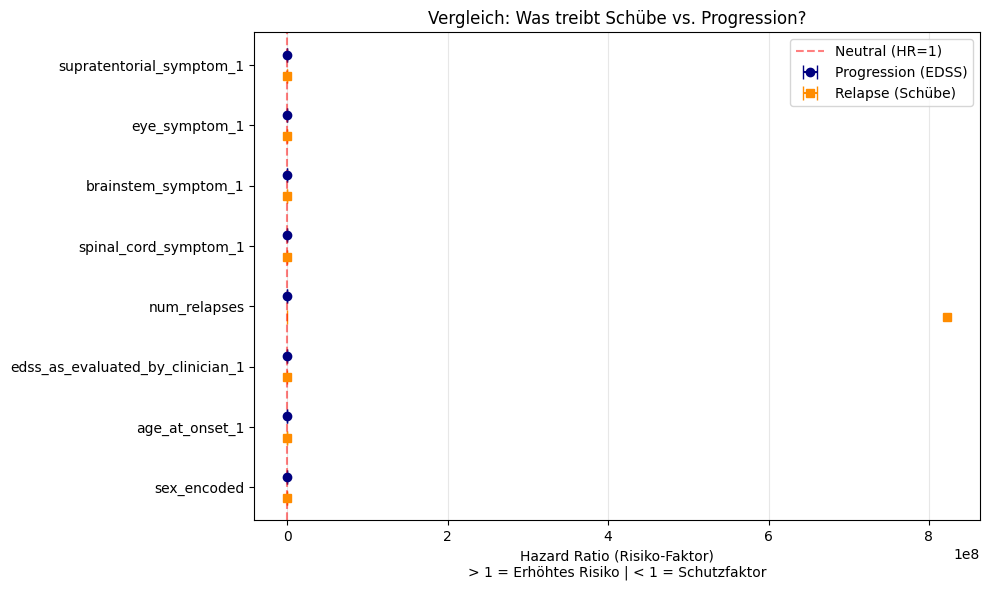

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Funktion zum Extrahieren der Daten für den Plot
def get_plot_data(cph_model, label):
    df = cph_model.summary[['coef', 'coef lower 95%', 'coef upper 95%']].copy()
    df.columns = ['coef', 'lower', 'upper']
    df['model'] = label
    # Hazard Ratio berechnen (e^coef) für bessere Lesbarkeit
    df['HR'] = np.exp(df['coef'])
    df['HR_lower'] = np.exp(df['lower'])
    df['HR_upper'] = np.exp(df['upper'])
    return df

# Daten aus beiden Modellen holen
df_plot_rel = get_plot_data(cph_relapse, "Relapse (Akut)")
df_plot_prog = get_plot_data(cph_progression, "Progression (Langzeit)")

# Zusammenfügen
# Wir sortieren nach den Features des Progressions-Modells
features = df_plot_prog.index.tolist()
y_pos = np.arange(len(features))

# Plot erstellen
fig, ax = plt.subplots(figsize=(10, 6))

# Verschiebung für nebeneinanderliegende Balken
bar_width = 0.35

# 1. Progression (Blau)
ax.errorbar(
    x=df_plot_prog['HR'],
    y=y_pos + bar_width/2,
    xerr=[df_plot_prog['HR'] - df_plot_prog['HR_lower'], df_plot_prog['HR_upper'] - df_plot_prog['HR']],
    fmt='o', color='navy', label='Progression (EDSS)', capsize=5
)

# 2. Relapse (Orange) - ACHTUNG: num_relapses ist hier evtl. verzerrt, wir plotten es trotzdem zum Vergleich
ax.errorbar(
    x=df_plot_rel['HR'],
    y=y_pos - bar_width/2,
    xerr=[df_plot_rel['HR'] - df_plot_rel['HR_lower'], df_plot_rel['HR_upper'] - df_plot_rel['HR']],
    fmt='s', color='darkorange', label='Relapse (Schübe)', capsize=5
)

# Layout
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.axvline(x=1, color='red', linestyle='--', alpha=0.5, label='Neutral (HR=1)')
ax.set_xlabel('Hazard Ratio (Risiko-Faktor)\n> 1 = Erhöhtes Risiko | < 1 = Schutzfaktor')
ax.set_title('Vergleich: Was treibt Schübe vs. Progression?')
ax.legend()
ax.grid(True, axis='x', alpha=0.3)

# Zoom anpassen, falls Ausreißer (wie num_relapses) die Skala sprengen
# ax.set_xlim(0, 5) # Optional: Entkommentieren, um extrem große Werte abzuschneiden

plt.tight_layout()
plt.show()

In [11]:
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.5
    Uninstalling osqp-1.0.5:
      Successfully uninstalled osqp-1.0.5
